In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
df=pd.read_excel("premiums_young_with_gr.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [3]:
df.shape

(20096, 14)

In [4]:
df.columns=df.columns.str.replace(' ','_').str.lower() 
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


**Handaling NA Values**

In [5]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [7]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [9]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [10]:
df['number_of_dependants']= abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [11]:
numeric_columns=df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

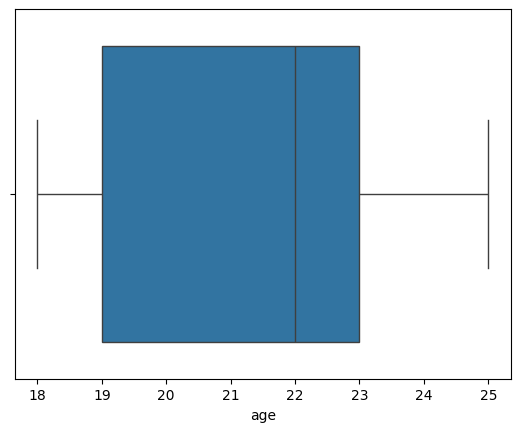

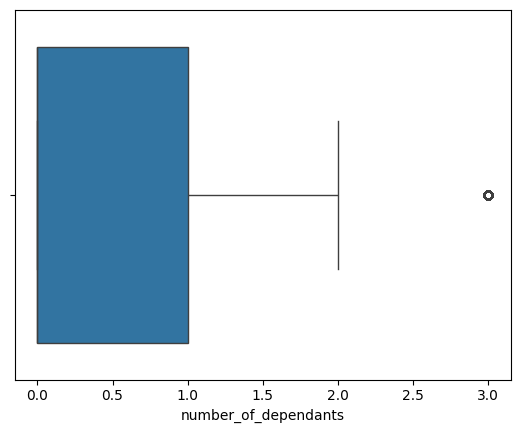

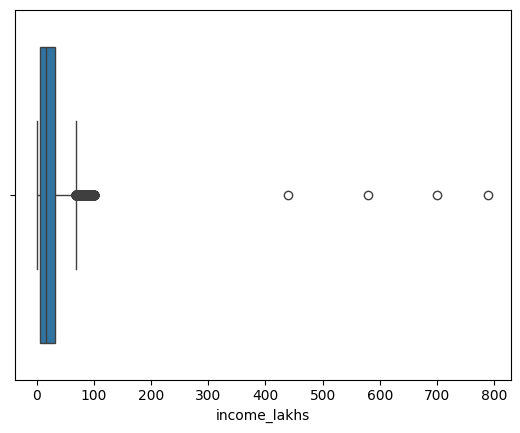

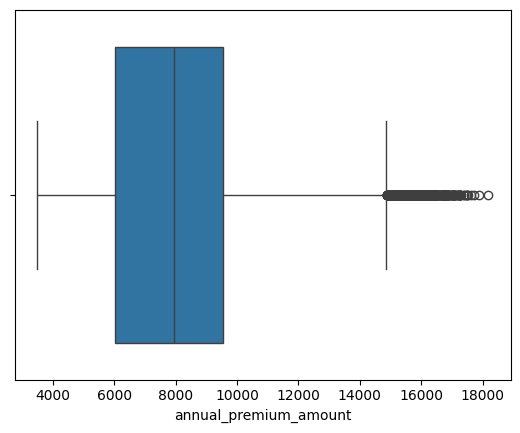

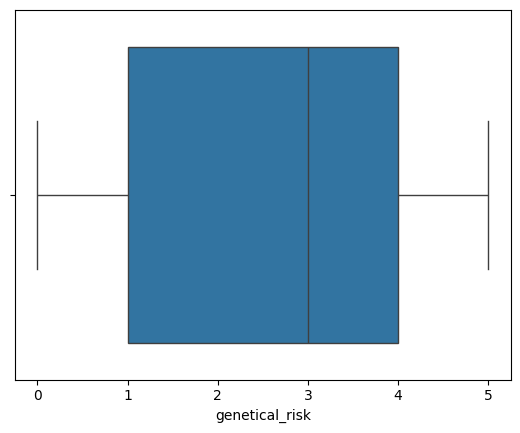

In [12]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [13]:
df[df.age>100]['age'].unique()

array([], dtype=int64)

In [14]:
df1=df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [15]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [16]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    return lower_bound,upper_bound

In [17]:
quantile_thresold =df1.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [18]:
df2=df1[df1.income_lakhs<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


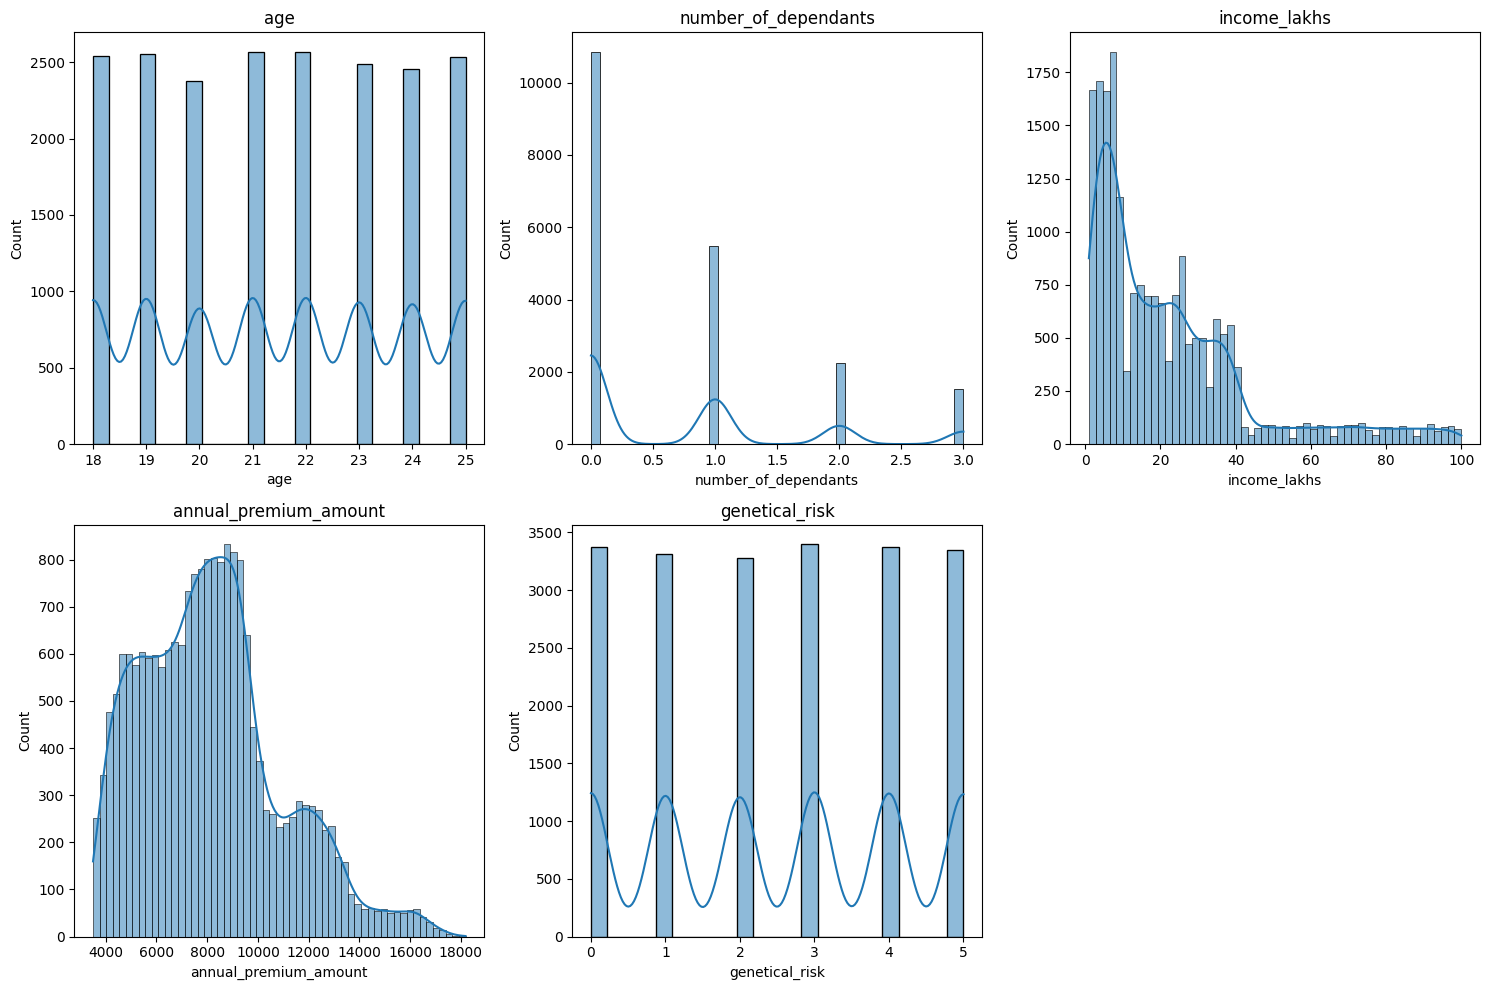

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  

for i, column in enumerate(numeric_columns):
    ax = axs[i // 3, i % 3] 
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)


if len(numeric_columns) % 3 != 0:
    for j in range(len(numeric_columns), 6):  
        axs.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

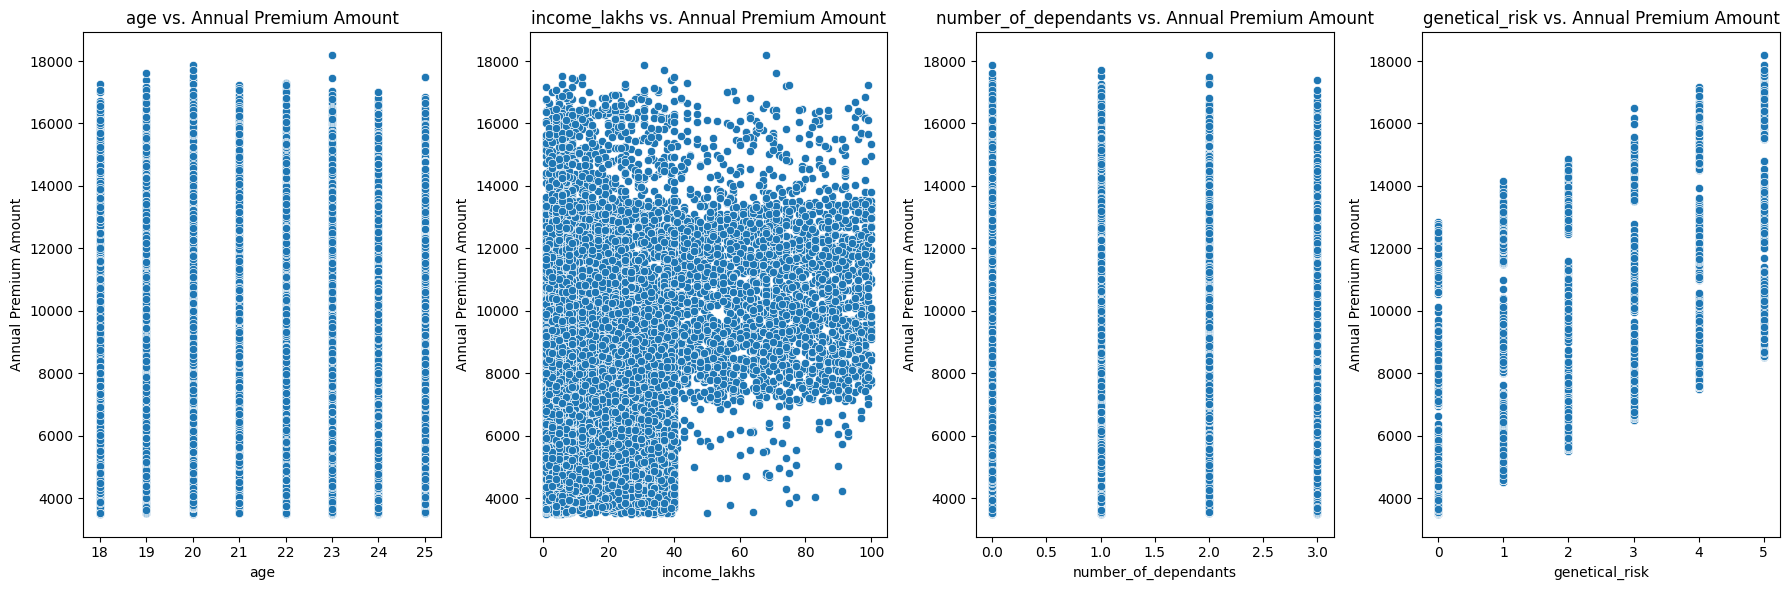

In [22]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants','genetical_risk']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  
plt.show()

In [23]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [24]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking',
},inplace=True)
df2['smoking_status'].unique()

C:\Users\niraj\AppData\Local\Temp\ipykernel_2620\2784352298.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [25]:
pct_count=df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

In [26]:
pct_count.values

array([0.55038335, 0.44961665])

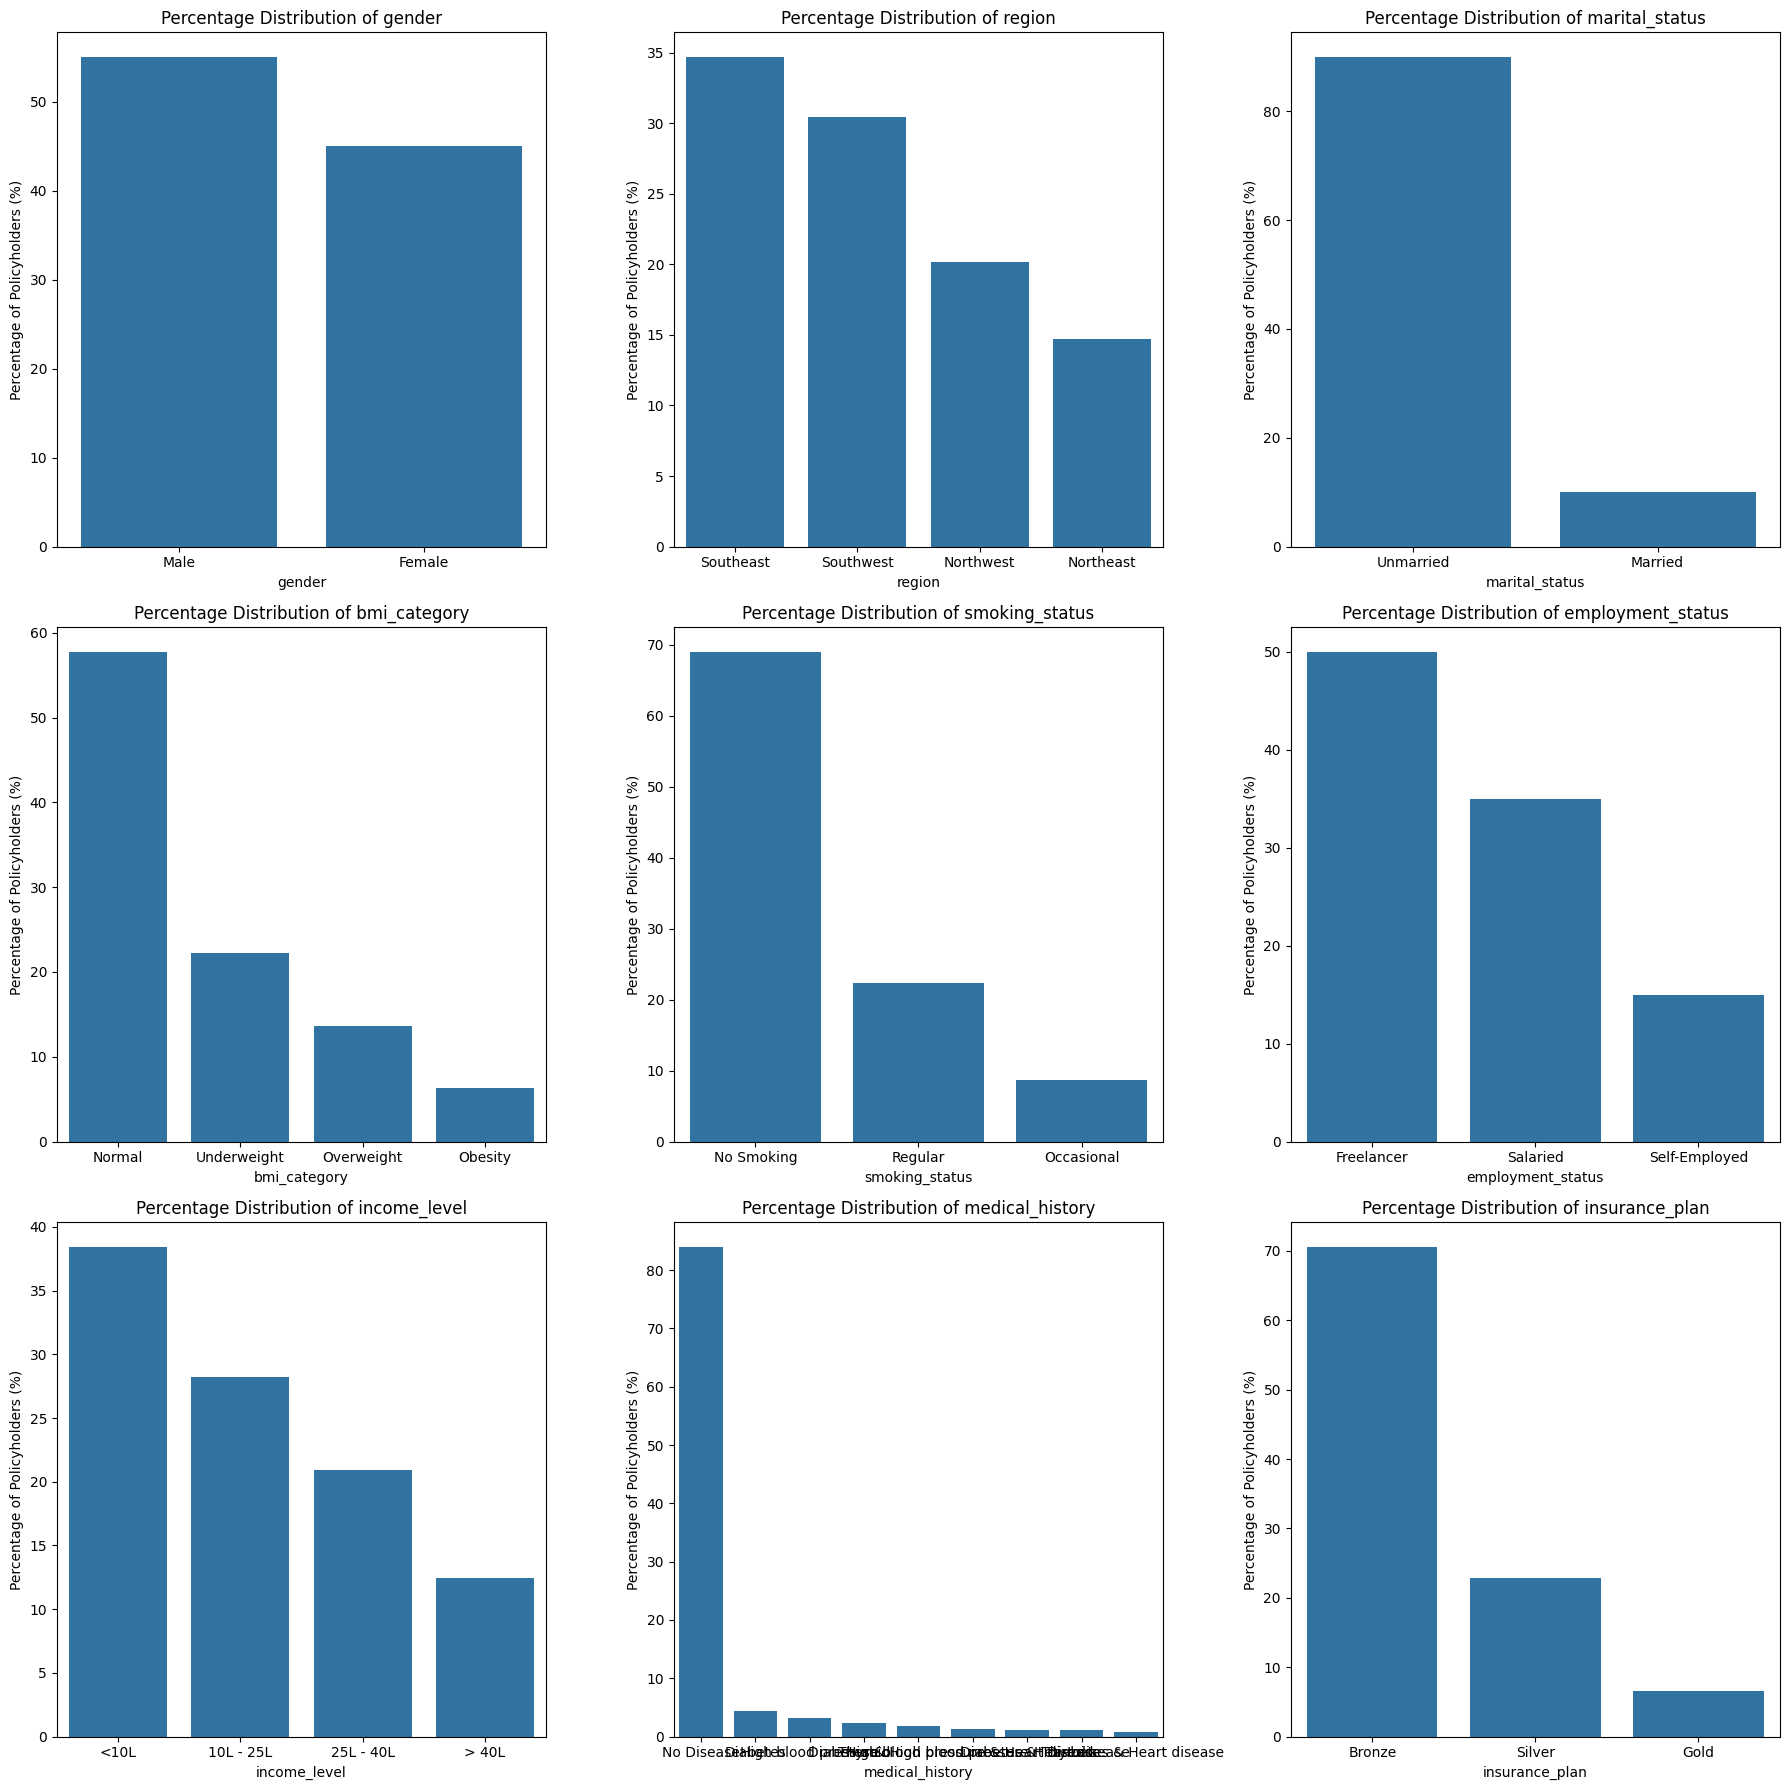

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


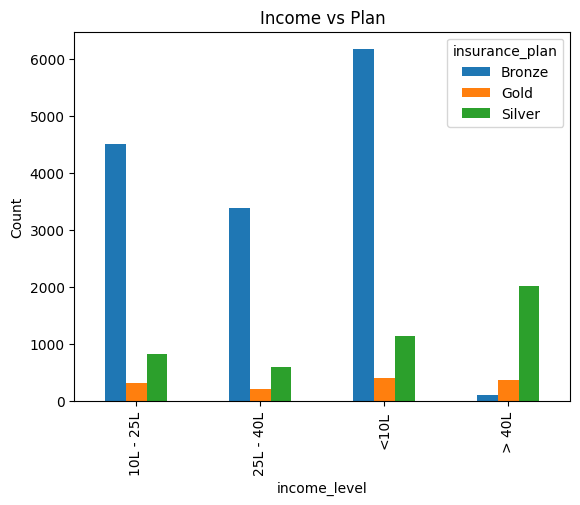

In [28]:
crosstab= pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

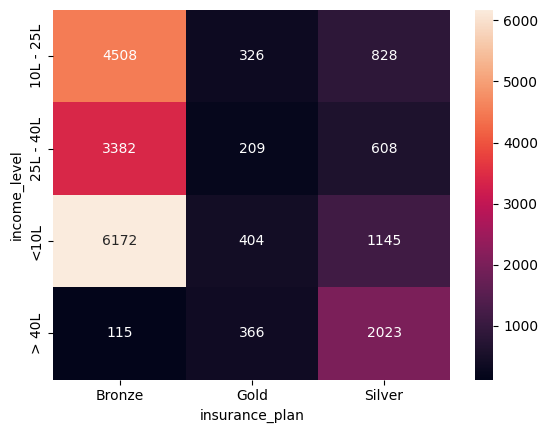

In [29]:
sns.heatmap(crosstab,annot=True,fmt='d')

In [30]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


In [31]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [32]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)


max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

C:\Users\niraj\AppData\Local\Temp\ipykernel_2620\1890634389.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\niraj\AppData\Local\Temp\ipykernel_2620\1890634389.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


In [33]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [34]:
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':1,'Silver':2,'Gold':3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [35]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000


In [36]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [37]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   genetical_risk                   20086 non-null  int64  
 8   disease1                         20086 non-null  object 
 9   disease2                         20086 non-null  object 
 10  total_risk_score                 20086 non-null  int64  
 11  normalized_risk_score            20086 non-null  float64
 12  gender_Male            

In [38]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3) 

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


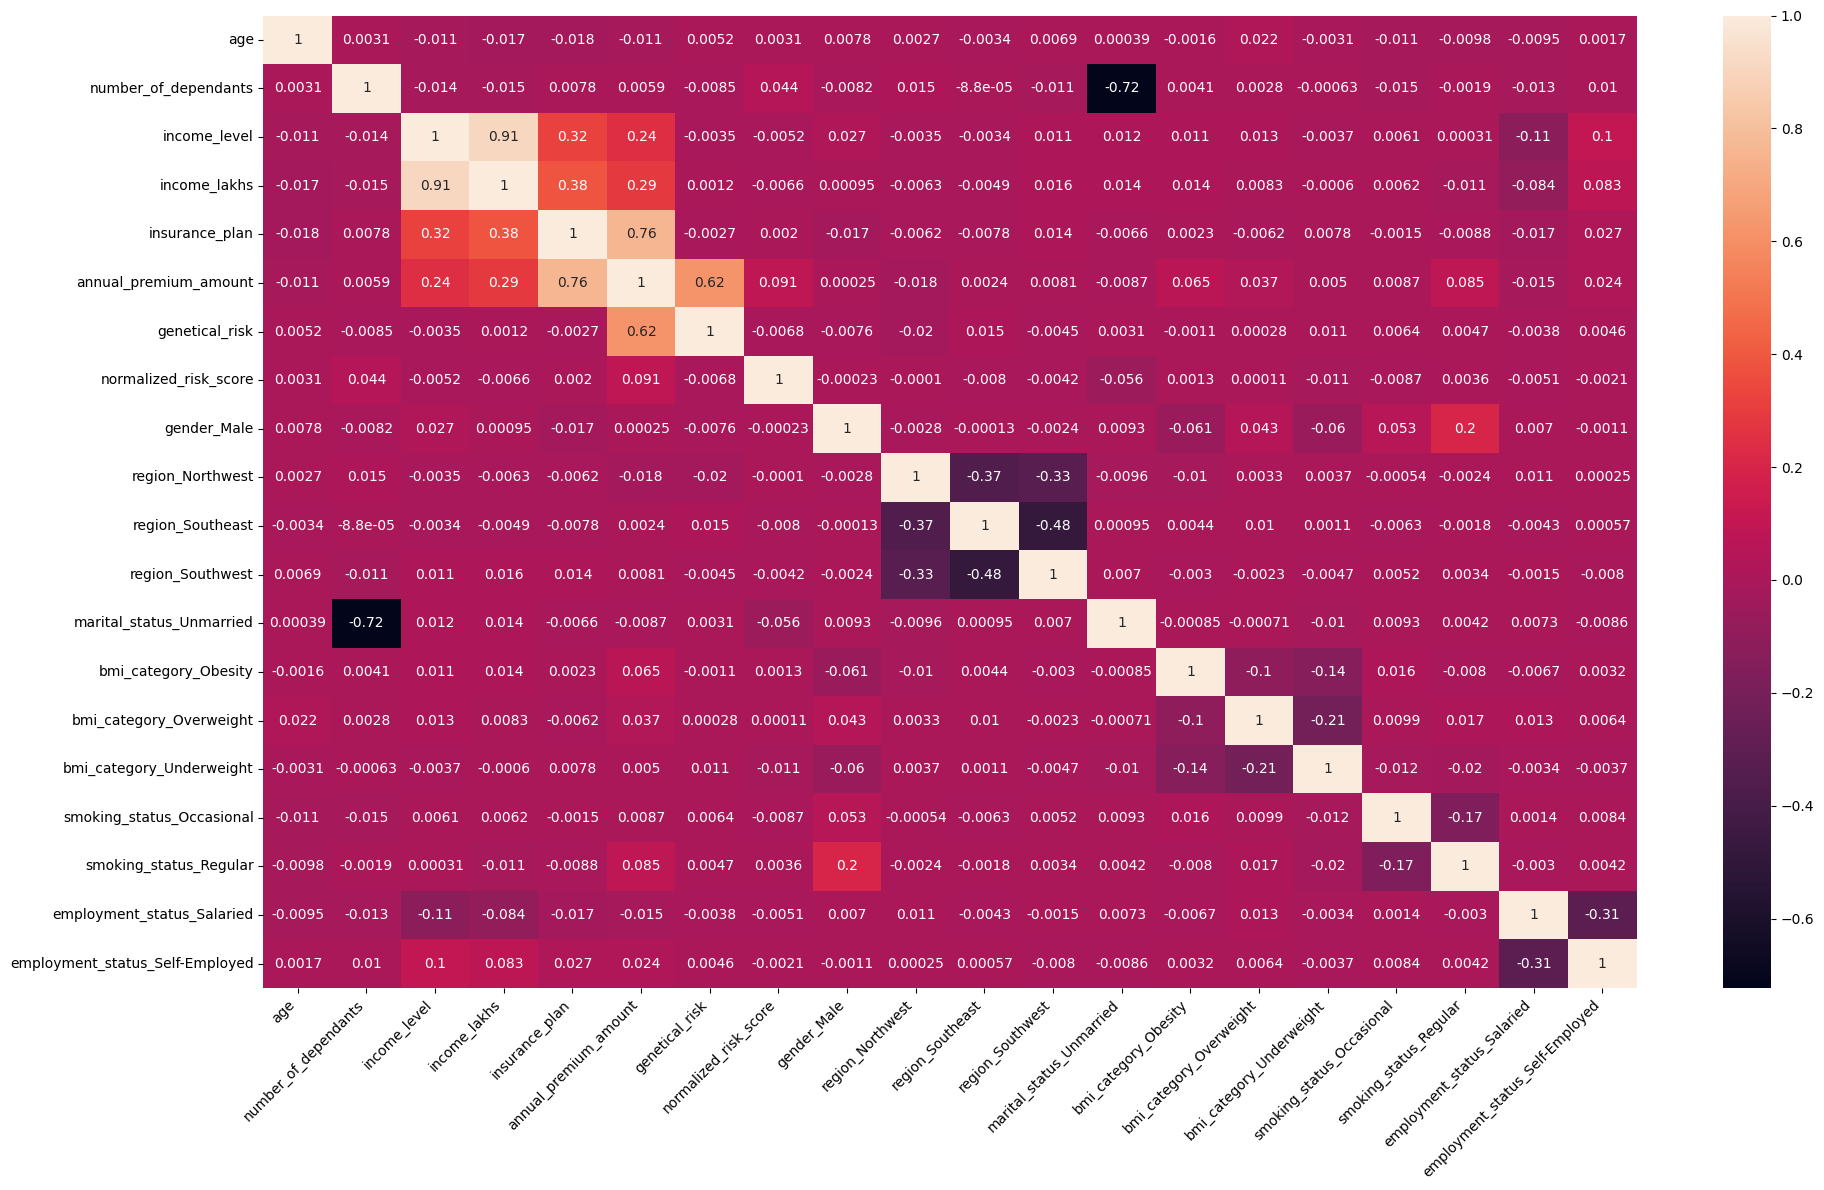

In [39]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [38]:
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [42]:
X=df4.drop('annual_premium_amount',axis='columns')
y=df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan','genetical_risk']
scaler=MinMaxScaler()

X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [44]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [45]:
calculate_vif(X.drop('income_level',axis='columns'))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [46]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


**Model Training**

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.30,random_state=10)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


In [51]:
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
train_score=model_lr.score(X_train,y_train)
test_score=model_lr.score(X_test,y_test)
train_score,test_score

(np.float64(0.988297900194864), np.float64(0.9887263253056615))

In [52]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  85732.34377930452 RMSE:  292.8008602776032


In [53]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.4,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [54]:
model_lr.intercept_

np.float64(3978.8235284382563)

In [55]:
model_lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

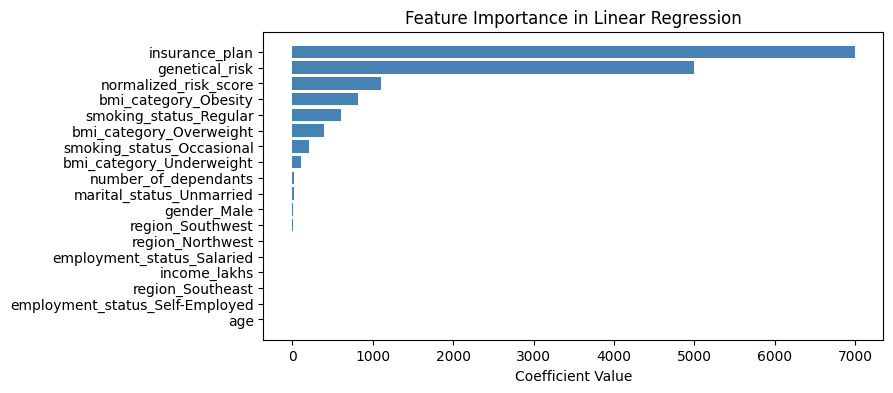

In [57]:
feature_importance=model_lr.coef_
coef_df=pd.DataFrame(feature_importance,index=X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [58]:
model_rg=Ridge(alpha=10)
model_rg.fit(X_train,y_train)
train_score=model_rg.score(X_train,y_train)
test_score=model_rg.score(X_test,y_test)
train_score,test_score

(np.float64(0.9882386209794508), np.float64(0.9886848419551753))

In [59]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  86047.81011671726 RMSE:  293.3390702186077


In [60]:
from xgboost import XGBRegressor

model_xgb=XGBRegressor()
model_xgb.fit(X_train,y_train)
train_score=model_xgb.score(X_train,y_train)
test_score=model_xgb.score(X_test,y_test)
train_score,test_score

(np.float64(0.9925054809841402), np.float64(0.987729520869432))

In [61]:
_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  86047.81011671726 RMSE:  293.3390702186077


In [62]:
model_xgb=XGBRegressor()
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
}
random_search=RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42,n_jobs=-1)
random_search.fit(X_train,y_train)
random_search.best_score_

np.float64(0.9879225990497197)

In [63]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [64]:
best_model= model_lr

**Error Analysis**

In [65]:
y_pred=best_model.predict(X_test)

residuals=y_pred-y_test
residuals_pct=residuals*100/y_test

results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916
19351,4917,5112.056543,195.056543,3.966983


<Axes: xlabel='diff_pct', ylabel='Count'>

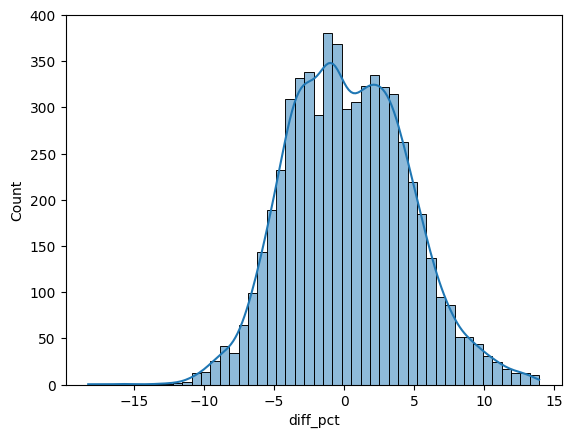

In [66]:
sns.histplot(results_df['diff_pct'],kde=True)

In [69]:
extreme_error_threshold=10

extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(129, 4)

In [70]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

2.140723531364089

In [71]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct',ascending=False)

,actual,predicted,diff,diff_pct


In [72]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [73]:
extreme_results_df.index

Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [75]:
extreme_errors_df=X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


**Export the Model**

In [85]:
from joblib import dump

scaler_with_cols={
    'scaler':scaler,
    'cols_to_scale':cols_to_scale
}
dump(scaler_with_cols,"artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']